In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

# Random seed

In [223]:
random_seed = 23
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# Set frame dimensions

In [224]:
frame_height, frame_width = 32, 32
max_frame_per_class = 5500

# Dataset specify

In [7]:
dataset_directory = "dataset/videos/Set 2"
classes_list = ["Idle", "Back cleaning", "Screen cleaning", "Applying screen protector", "Checking back side"]

In [8]:
model_output_size = len(classes_list)

# Create dataset

In [227]:
# Declaring Empty Lists to store the features and labels values.
temp_features = [] 
features = []
labels = []

In [228]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (frame_height, frame_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [229]:
# Iterating through all the classes mentioned in the classes list
for class_index, class_name in enumerate(classes_list):
    print(f'Extracting Data of Class: {class_name}')
    
    # Getting the list of video files present in the specific class name directory
    files_list = os.listdir(os.path.join(dataset_directory, class_name))

    # Iterating through all the files present in the files list
    for file_name in files_list:

        # Construct the complete video path
        video_file_path = os.path.join(dataset_directory, class_name, file_name)

        # Calling the frame_extraction method for every video file path
        frames = frames_extraction(video_file_path)

        # Appending the frames to a temporary list.
        temp_features.extend(frames)
    
    # Adding randomly selected frames to the features list
    features.extend(random.sample(temp_features, max_frame_per_class))

    # Adding Fixed number of labels to the labels list
    labels.extend([class_index] * max_frame_per_class)
    
    # Emptying the temp_features list so it can be reused to store all frames of the next class.
    temp_features.clear()

# Converting the features and labels lists to numpy arrays
features = np.asarray(features)
labels = np.array(labels)

Extracting Data of Class: Idle
Extracting Data of Class: Back cleaning
Extracting Data of Class: Screen cleaning
Extracting Data of Class: Applying screen protector
Extracting Data of Class: Checking back side


# Convert labels into one-hot-encoded vectors

In [230]:
one_hot_encoded_labels = to_categorical(labels)

In [231]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = random_seed)

# Create model

In [9]:
# We will use a Sequential model for model construction
model = Sequential()

# Defining The Model Architecture
model.add(Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu', input_shape = (frame_height, frame_width, 3)))
model.add(Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(model_output_size, activation = 'softmax'))

In [233]:
# Printing the models summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 31, 32)        416       
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        4128      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_5   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                      

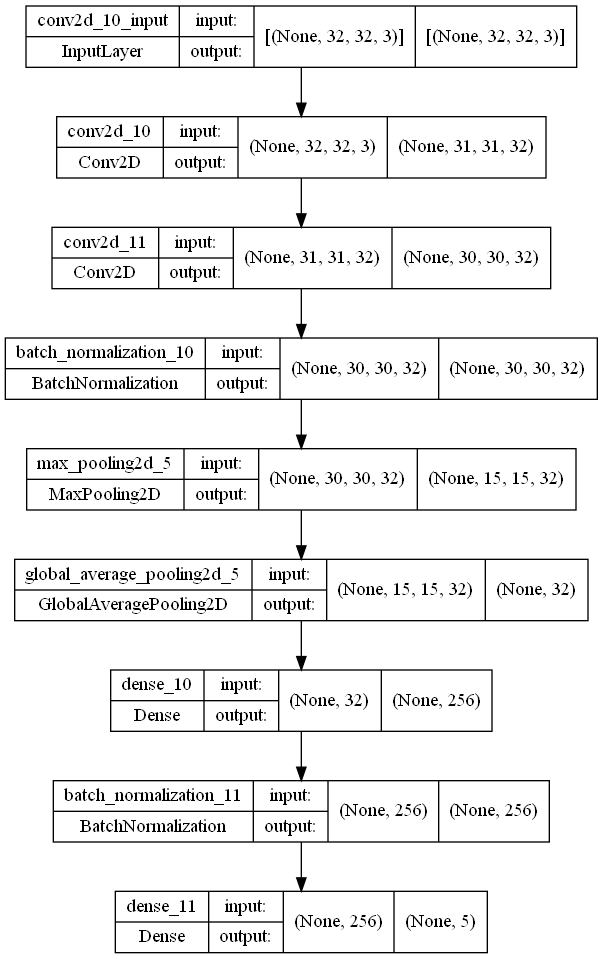

In [234]:
# Plot model
plot_model(model, to_file = 'video_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Model optimizing

In [235]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

In [236]:
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Model training

In [237]:

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
4400/4400 [==============================] - 31s 7ms/step - loss: 0.7092 - accuracy: 0.7442 - val_loss: 0.4229 - val_accuracy: 0.8473
Epoch 2/100
4400/4400 [==============================] - 30s 7ms/step - loss: 0.4010 - accuracy: 0.8671 - val_loss: 0.3860 - val_accuracy: 0.8723
Epoch 3/100
4400/4400 [==============================] - 30s 7ms/step - loss: 0.3197 - accuracy: 0.8952 - val_loss: 0.3728 - val_accuracy: 0.8682
Epoch 4/100
4400/4400 [==============================] - 30s 7ms/step - loss: 0.2799 - accuracy: 0.9105 - val_loss: 0.1235 - val_accuracy: 0.9698
Epoch 5/100
4400/4400 [==============================] - 26s 6ms/step - loss: 0.2456 - accuracy: 0.9232 - val_loss: 0.1069 - val_accuracy: 0.9659
Epoch 6/100
4400/4400 [==============================] - 25s 6ms/step - loss: 0.2179 - accuracy: 0.9314 - val_loss: 0.1380 - val_accuracy: 0.9586
Epoch 7/100
4400/4400 [==============================] - 28s 6ms/step - loss: 0.1966 - accuracy: 0.9418 - val_loss: 0.2690 -

In [238]:
model_evaluation_history = model.evaluate(features_test, labels_test)

172/172 [==============================] - 1s 4ms/step - loss: 0.0873 - accuracy: 0.9762


# Save model

In [239]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'dataset/videos/Set 2/Model_Video_Date-{current_date_time_string}_Loss-{model_evaluation_loss}_Accuracy-{model_evaluation_accuracy}.h5'
tflite_save_path = f'dataset/videos/Set 2/Model_Video_Date-{current_date_time_string}_Loss-{model_evaluation_loss}_Accuracy-{model_evaluation_accuracy}.tflite'

In [240]:
# Saving your Model
model.save(model_name)

# Plot Model’s Loss and Accuracy Curves

In [241]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
    # Get Metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Constructing a range object which will be used as time 
    epochs = range(len(metric_value_1))
    
    # Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    
    # Adding title to the plot
    plt.title(str(plot_name))

    # Adding legend to the plot
    plt.legend()

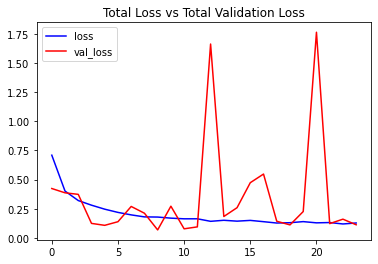

In [242]:
# Loss
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

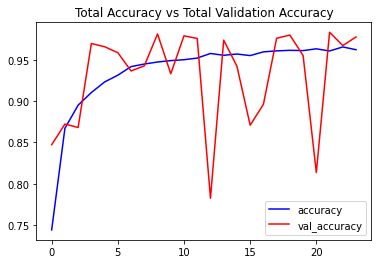

In [243]:
# Accuracy
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Load model

In [244]:
# Loading the saved model
model = tf.keras.models.load_model(model_name)

In [245]:
# Inference test
predict_result = model.predict(np.array([features_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.4970226e-04 2.3654367e-13 6.8400987e-14 9.9973077e-01 1.1955582e-04]
3


# Convert to model for Tensorflow-Lite

In [246]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\sttbeng\AppData\Local\Temp\tmp4me975lv\assets


INFO:tensorflow:Assets written to: C:\Users\sttbeng\AppData\Local\Temp\tmp4me975lv\assets


21568

# Inference test

In [247]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [248]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [249]:
interpreter.set_tensor(input_details[0]['index'], np.array([features_test[0]], dtype=np.float32))

In [250]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 31.2 ms
Wall time: 27.9 ms


In [251]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5277615e-04 3.7294286e-13 5.9596527e-14 9.9969912e-01 1.4814649e-04]
3
